# File Report Analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%%capture
!jupyter nbextension enable --py --sys-prefix qgrid
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
import pandas as pd
import numpy as np
import json
import qgrid
import ipywidgets as widgets
import ipython_blocking
from graphviz import Digraph
import matplotlib.pyplot as plt

### So far we only have a report for scenario-1

In [5]:
scenarios = ['scenario-1', 'scenario-2']

selected_scenario = widgets.Dropdown(
    options     = scenarios,
    description = 'Scenario : ',
    disabled    = False,
    value       = None)

button = widgets.Button(description='Run')

box = widgets.VBox(children=[selected_scenario, button])
display(box)

<IPython.core.display.Javascript object>

In [8]:
%blockrun button

In [9]:
scenario = selected_scenario.value

hash_path = '/home/jovyan/test_data/'+scenario+'/hd2/status/hash.json'

with open(hash_path) as json_file:
    data = json.load(json_file)
    
files = [elem['file_name'] for elem in data]

selected_file = widgets.Dropdown(
    options     = files,
    description = 'File : ',
    disabled    = False,
    value       = None)

button = widgets.Button(description='Run')

box = widgets.VBox(children=[selected_file, button])
display(box)

<IPython.core.display.Javascript object>

In [12]:
%blockrun button

In [13]:
i = files.index(selected_file.value)
folder_hash = data[i]['original_hash']

file ='/home/jovyan/test_data/'+scenario+'/hd2/data/'+folder_hash+'/report.json'

df0 = pd.read_json(file)
df0 = df0.reset_index()

info = df0.iloc[3]['gw:GWallInfo']

df = pd.DataFrame.from_dict(info)

## Document Summary

In [14]:
d = info['gw:DocumentSummary']

for key in d:
    d[key] = [d[key]]
    
document_summary = pd.DataFrame.from_dict(d)

document_summary.rename(columns={'gw:TotalSizeInBytes':'Total Size In Bytes',  
                                 'gw:FileType':'File Type',
                                 'gw:Version':'Version'}, inplace=True)

print('Total Size In Bytes :', document_summary['Total Size In Bytes'].iloc[0])
print('File Type :', document_summary['File Type'].iloc[0])
print('Version :', document_summary['Version'].iloc[0])

Total Size In Bytes : 7817
File Type : jpeg
Version : Not Applicable


## Extracted Items

In [15]:
d = info['gw:ExtractedItems']

for key in d:
    d[key] = [d[key]]
    
extracted_items = pd.DataFrame.from_dict(d)

extracted_items.rename(columns={'@itemCount':'Item Count'}, inplace=True)

print("Item Count :", extracted_items['Item Count'].iloc[0])

Item Count : 0


## Content Management Policy

In [16]:
d = info['gw:ContentManagementPolicy']['gw:Camera']

df0 = pd.DataFrame.from_dict(d)

data = info['gw:ContentManagementPolicy']['gw:Camera'][0]['gw:ContentSwitch']

if len(data) == 2:
    for key in data:
        data[key] = [data[key]]

df = pd.DataFrame.from_dict(data)
df['@cameraName'] = df0.iloc[0]['@cameraName']
df = df[['@cameraName', 'gw:ContentName', 'gw:ContentValue']]

for i in range(1, len(df0)):
    data = info['gw:ContentManagementPolicy']['gw:Camera'][i]['gw:ContentSwitch']

    if len(data) == 2:
        for key in data:
            data[key] = [data[key]]
    
    df1 = pd.DataFrame.from_dict(data)
    df1['@cameraName'] = df0.iloc[i]['@cameraName']
    df1 = df1[['@cameraName', 'gw:ContentName', 'gw:ContentValue']]
    
    df = pd.concat([df, df1], ignore_index=True)
    
content_management_policy = df

content_management_policy.rename(columns={'@cameraName':'Camera Name', 
                                          'gw:ContentName':'Content Name', 
                                          'gw:ContentValue':'Content Value'}, inplace=True) 

In [17]:
qgrid_widget = qgrid.show_grid(content_management_policy, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [18]:
camera_names = list(content_management_policy['Camera Name'].unique())

selected_camera = widgets.Dropdown(
    options     = camera_names,
    description = 'Camera : ',
    disabled    = False,
    value       = None)

button = widgets.Button(description='Run')

box = widgets.VBox(children=[selected_camera, button])
display(box)

<IPython.core.display.Javascript object>

In [21]:
%blockrun button

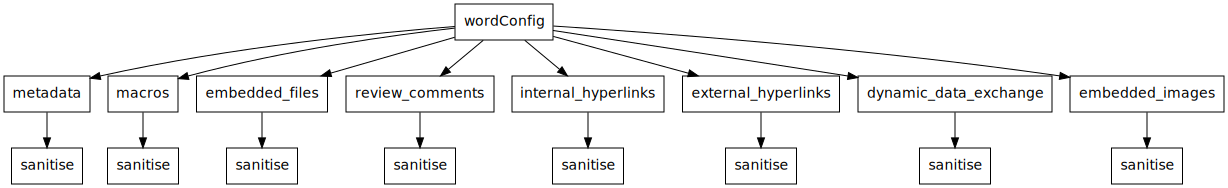

In [22]:
elem = selected_camera.value

gra = Digraph()
    
# root node
gra.node(elem, shape='box')
    
df0 = content_management_policy[content_management_policy['Camera Name']==elem]
    
content_name = list(df0['Content Name'].unique())
    
with gra.subgraph() as i:
    i.attr(rank='same')   
    for elem2 in content_name:
        i.node(elem2, shape='box')
            
for elem2 in content_name:
    df00 = df0[df0['Content Name']==elem2]
    k = int(df00.index[0])
    text = df00.iloc[0]['Content Value']
    gra.node(str(k), text, shape='box')
    gra.edge(elem2, str(k))

for elem3 in df0['Content Name']:
    gra.edge(elem, elem3)
        
gra

## Content Groups

In [23]:
# Number of groups
num_groups = info['gw:ContentGroups']['@groupCount']

print("There are " + num_groups + " groups")

There are 3 groups


In [24]:
d = info['gw:ContentGroups']['gw:ContentGroup'][0]['gw:ContentItems']['gw:ContentItem']

df = pd.DataFrame.from_dict(d)
df['gw:BriefDescription'] = info['gw:ContentGroups']['gw:ContentGroup'][0]['gw:BriefDescription']
df = df[['gw:BriefDescription', 'gw:TechnicalDescription', 'gw:InstanceCount', 'gw:TotalSizeInBytes', 'gw:AverageSizeInBytes', 'gw:MinSizeInBytes', 'gw:MaxSizeInBytes']]

for i in range(1, int(num_groups)):
    
    df1 = pd.DataFrame.from_dict(d)
    df1['gw:BriefDescription'] = info['gw:ContentGroups']['gw:ContentGroup'][i]['gw:BriefDescription']
    df1 = df1[['gw:BriefDescription', 'gw:TechnicalDescription', 'gw:InstanceCount', 'gw:TotalSizeInBytes', 'gw:AverageSizeInBytes', 'gw:MinSizeInBytes', 'gw:MaxSizeInBytes']]
    
    df = pd.concat([df, df1], ignore_index=True)
    
content_groups = df

content_groups.rename(columns={'gw:BriefDescription':'Brief Description', 
                               'gw:TechnicalDescription':'Technical Description',
                               'gw:InstanceCount':'Instance Count',
                               'gw:TotalSizeInBytes':'Total Size In Bytes',
                               'gw:AverageSizeInBytes':'Average Size In Bytes',
                               'gw:MinSizeInBytes':'Min Size In Bytes',
                               'gw:MaxSizeInBytes':'Max Size In Bytes'}, inplace=True)

In [25]:
qgrid_widget = qgrid.show_grid(content_groups, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [26]:
groups = list(content_groups['Brief Description'].unique())

selected_group = widgets.Dropdown(
    options     = groups,
    description = 'Groups : ',
    disabled    = False,
    value       = None)

button = widgets.Button(description='Run')

box = widgets.VBox(children=[selected_group, button])
display(box)

<IPython.core.display.Javascript object>

In [29]:
%blockrun button

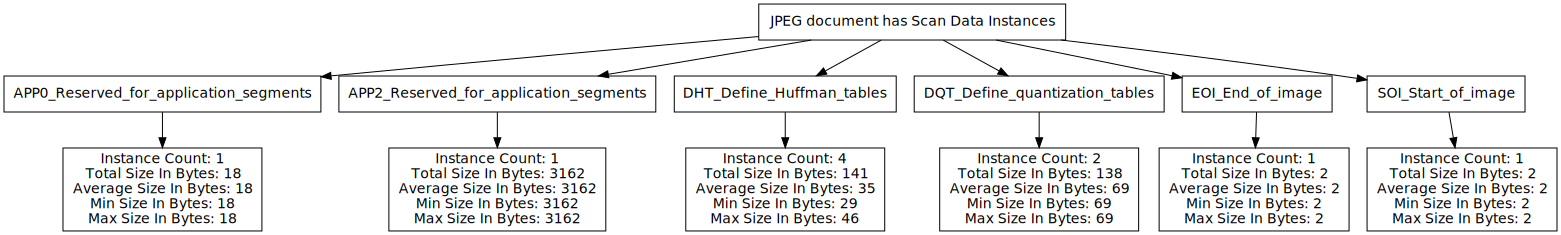

In [30]:
elem = selected_group.value

gra = Digraph()
    
# root node
gra.node(elem, shape='box')
    
df0 = content_groups[content_groups['Brief Description']==elem]
    
tech_description = list(df0['Technical Description'].unique())
    
with gra.subgraph() as i:
    i.attr(rank='same')   
    for elem2 in tech_description:
        i.node(elem2, shape='box')

for elem3 in df0['Technical Description']:
    gra.edge(elem, elem3)
    
for elem2 in tech_description:
    k = tech_description.index(elem2)
    df00 = df0[df0['Technical Description']==elem2].reset_index()       
    text = 'Instance Count: ' + df00['Instance Count'].iloc[0]
    text += '\nTotal Size In Bytes: ' + df00['Total Size In Bytes'].iloc[0]
    text += '\nAverage Size In Bytes: ' + df00['Average Size In Bytes'].iloc[0]
    text += '\nMin Size In Bytes: ' + df00['Min Size In Bytes'].iloc[0]
    text += '\nMax Size In Bytes: ' + df00['Max Size In Bytes'].iloc[0]
    
    gra.node(str(k), text, shape='box')
    gra.edge(elem2, str(k))
        
gra

In [31]:
df1 = df0.set_index('Technical Description')

df1["Instance Count"] = pd.to_numeric(df1["Instance Count"])
df1["Total Size In Bytes"] = pd.to_numeric(df1["Total Size In Bytes"])
df1["Average Size In Bytes"] = pd.to_numeric(df1["Average Size In Bytes"])
df1["Min Size In Bytes"] = pd.to_numeric(df1["Min Size In Bytes"])
df1["Max Size In Bytes"] = pd.to_numeric(df1["Max Size In Bytes"])

df1 = df1.drop(columns='Brief Description')

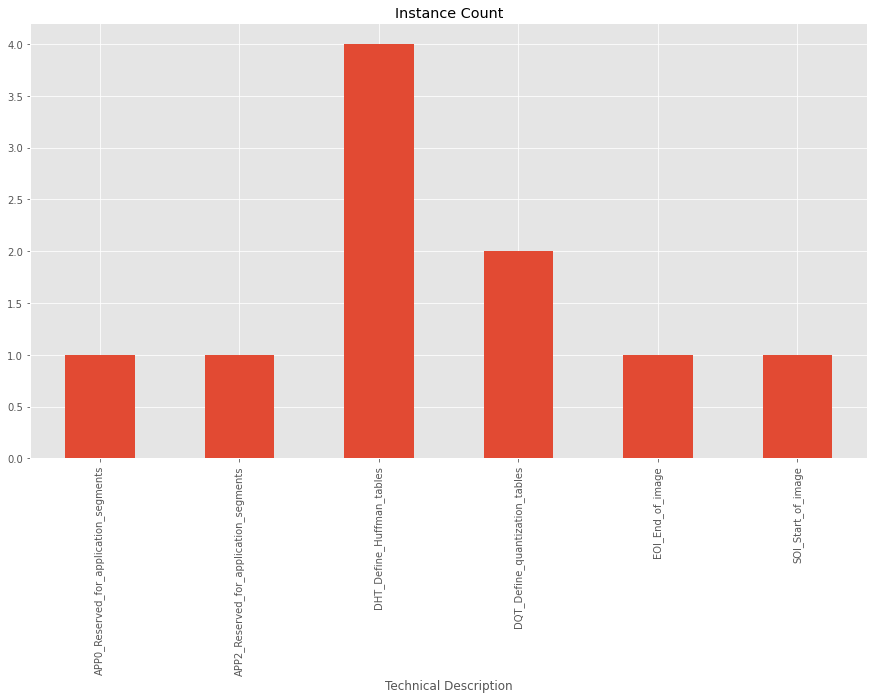

In [32]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(15, 8))
    df1['Instance Count'].plot(kind='bar', color='C0', title='Instance Count');

In [33]:
df1 = df1.T

In [34]:
selected_tech = widgets.Dropdown(
    options     = tech_description,
    description = 'Tech : ',
    disabled    = False,
    value       = None)

button = widgets.Button(description='Run')

box = widgets.VBox(children=[selected_tech, button])
display(box)

<IPython.core.display.Javascript object>

In [37]:
%blockrun button

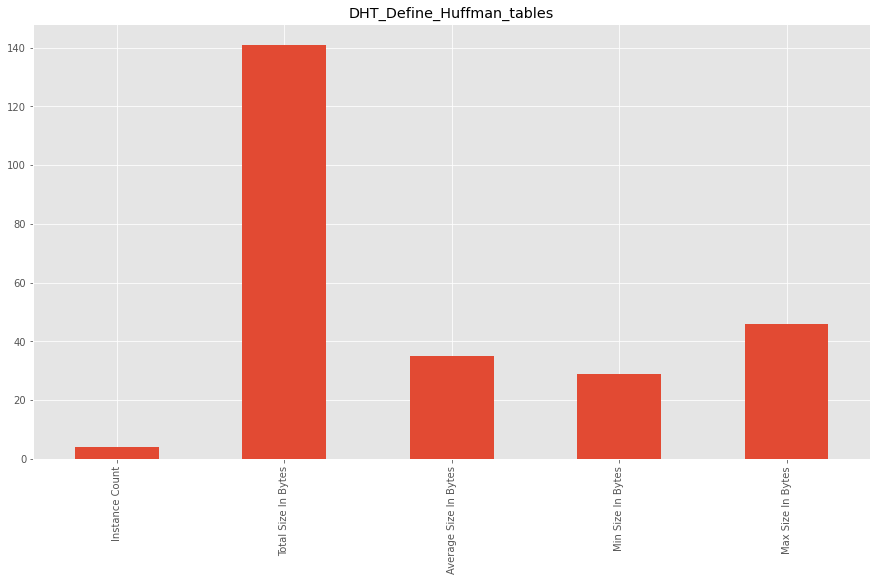

In [38]:
tech = selected_tech.value

with plt.style.context('ggplot'):
    plt.figure(figsize=(15,8))
    df1[tech].plot(kind='bar', color='C0', title=tech);

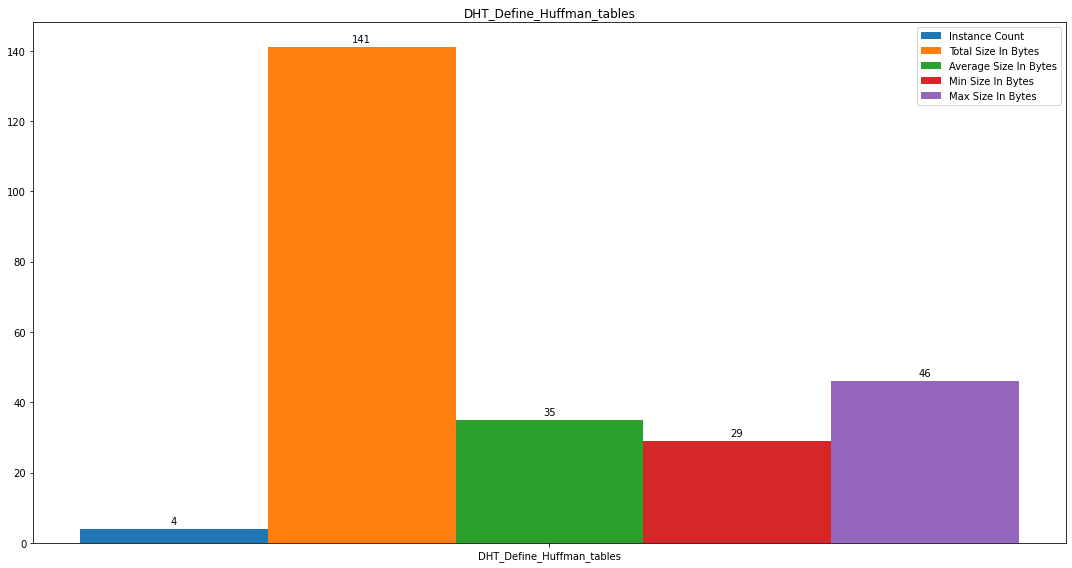

In [39]:
labels = [tech]

count = [df1[tech].iloc[0]]
total = [df1[tech].iloc[1]]
average = [df1[tech].iloc[2]]
min_ = [df1[tech].iloc[3]]
max_ = [df1[tech].iloc[4]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8))
rects1 = ax.bar(x - 2*width, count, width, label='Instance Count')
rects2 = ax.bar(x - width, total, width, label='Total Size In Bytes')
rects3 = ax.bar(x , average, width, label='Average Size In Bytes')
rects4 = ax.bar(x + width, min_, width, label='Min Size In Bytes')
rects5 = ax.bar(x + 2*width, max_, width, label='Max Size In Bytes')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(tech)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)
ax.bar_label(rects5, padding=3)

fig.tight_layout()

plt.show()